# Projekt: Lokalizacja punktu w przestrzeni dwuwymiarowej – Metoda Separatorów
**Autorzy:** Gabriel Wermiński, Jacek Łoboda
**Przedmiot:** Algorytmy Geometryczne

## 1. Wstęp Teoretyczny
Problem lokalizacji punktu polega na znalezieniu regionu $R_i$ w podziale płaszczyzny, który zawiera dany punkt zapytania. W tym projekcie prezentujemy **Metodę separatorów**.

### Główne założenia metody:
1.  **Monotoniczność:** Podział płaszczyzny składa się z obszarów monotoniczny. Jeśli obszary nie są monotoniczne, wymagana jest regularyzacja (np. triangulacja).
2.  **Separatory:** Konstruujemy zbiór łańcuchów monotonicznych, które uporządkowują obszary od lewej do prawej.

Struktura danych to drzewo binarne, gdzie węzły reprezentują łańcuchy, a liście reprezentują regiony. Zapytanie o punkt polega na porównaniu położenia punktu względem kolejnych łańcuchów w drzewie, co pozwala na osiągnięcie logarytmicznego czasu zapytania.


In [100]:
import math
import random
import bisect
from typing import List , Tuple , Optional , Union , Any
from functools import cmp_to_key
import matplotlib as plt
import numpy as np
import pandas as pd
from bitalg.visualizer.main import Visualizer
from time import time
import os

In [101]:
eps = 1e-24


class Vertex:
    def __init__(self, x_coord: float, y_coord: float):
        self.x = x_coord
        self.y = y_coord
        self.adj_out: List[Tuple['Vertex', int]] = []
        self.adj_in: List[Tuple['Vertex', int]] = []
        self.accumulated_weight_in = 0
        self.accumulated_weight_out = 0

    @property
    def coords(self) -> Tuple[float, float]:
        return self.x, self.y

    def __repr__(self):
        return f"V({self.x:.2f}, {self.y:.2f})"


class MonotoneChain:
    def __init__(self):
        self.path_vertices: List[Tuple[float, float]] = []
        self.path_segments: List[Tuple[Tuple[float, float], Tuple[float, float]]] = []
        self.id = -1  # NOWE: ID potrzebne do mapowania regionów

    def add_node(self, coords: Tuple[float, float]):
        self.path_vertices.append(coords)

    def add_segment(self, start: Tuple[float, float], end: Tuple[float, float]):
        self.path_segments.append((start, end))

class SearchTreeNode:
    def __init__(self, segments: List, chain_ref: MonotoneChain, parent: Optional['SearchTreeNode'] = None):
        self.left_child: Optional[SearchTreeNode] = None
        self.right_child: Optional[SearchTreeNode] = None
        self.parent = parent
        self.segments = segments
        self.chain_ref = chain_ref

In [102]:
def ensure_image_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

## 2. Przetwarzanie Grafu i Wagi Planarne
Aby zbudować drzewo łańcuchów, musimy najpierw odpowiednio skierować krawędzie i nadać im wagi. Algorytm wykonuje dwa przejścia:
1.  Propagacja wag z dołu do góry.
2.  Korekta wag z góry na dół.

Celem jest ustalenie przepływu tak, aby każdy łańcuch mógł zostać wyodrębniony jako ścieżka monotoniczna od źródła do ujścia grafu.

In [103]:
def cross_product(o: Tuple[float, float], a: Tuple[float, float], b: Tuple[float, float]) -> float:
    return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

def build_graph(raw_vertices: List[Tuple[float, float]], raw_edges: List[Tuple[int, int]]) -> List[Vertex]:
    graph_nodes = [Vertex(x, y) for x, y in raw_vertices]
    for start_idx, end_idx in raw_edges:
        # Krawędzie zawsze w górę (lub w prawo przy równym Y)
        # Sortujemy tak, aby u był "mniejszy" (niżej/lewo) a v "większy"
        p1 = raw_vertices[start_idx]
        p2 = raw_vertices[end_idx]
        
        if p1[1] < p2[1] or (math.isclose(p1[1], p2[1], abs_tol=eps) and p1[0] < p2[0]):
            u, v = start_idx, end_idx
        else:
            u, v = end_idx, start_idx

        node_u = graph_nodes[u]
        node_v = graph_nodes[v]
        node_u.adj_out.append((node_v, 1))
        node_v.adj_in.append((node_u, 1))
    return graph_nodes

def compute_planar_weights(graph: List[Vertex]):
    for node in graph:
        center = node.coords
        
        def angular_comparator(edge1, edge2):
            p1 = edge1[0].coords
            p2 = edge2[0].coords
            cp = cross_product(center, p1, p2)
            if math.isclose(cp, 0, abs_tol=eps): return 0
            return -1 if cp > 0 else 1

        node.adj_out.sort(key=cmp_to_key(angular_comparator))
        node.adj_in.sort(key=cmp_to_key(lambda a, b: -1 * angular_comparator(a, b)))

    # Forward pass (dół -> góra)
    # Sortujemy topologicznie (po Y) dla poprawności przepływu
    sorted_nodes = sorted(graph, key=lambda v: (v.y, v.x))

    for v in sorted_nodes:
        # Pomiń jeśli to źródło (można to wykryć brakiem adj_in, ale dla bezpieczeństwa:)
        if not v.adj_in and v != sorted_nodes[0]: pass 

        v.accumulated_weight_in = sum(w for _, w in v.adj_in)
        if not v.adj_in: v.accumulated_weight_in = 0 # Źródło ma 0 wejścia z definicji przepływu, ale generuje łańcuchy

        v.accumulated_weight_out = len(v.adj_out)
        
        if v.accumulated_weight_in > v.accumulated_weight_out:
            if v.adj_out:
                target_node, current_w = v.adj_out.pop(0)
                new_weight = current_w + v.accumulated_weight_in - v.accumulated_weight_out
                v.adj_out.insert(0, (target_node, new_weight))
                
                for idx, (neighbor, w) in enumerate(target_node.adj_in):
                    if neighbor == v:
                        target_node.adj_in[idx] = (v, new_weight)
                        break

    # Backward pass (góra -> dół)
    for v in reversed(sorted_nodes):
        v.accumulated_weight_in = sum(w for _, w in v.adj_in)
        v.accumulated_weight_out = sum(w for _, w in v.adj_out)
        
        if v.accumulated_weight_out > v.accumulated_weight_in:
            if v.adj_in:
                source_node, current_w = v.adj_in.pop(0)
                new_weight = current_w + v.accumulated_weight_out - v.accumulated_weight_in
                v.adj_in.insert(0, (source_node, new_weight))
                
                for idx, (neighbor, w) in enumerate(source_node.adj_out):
                    if neighbor == v:
                        source_node.adj_out[idx] = (v, new_weight)
                        break

## 3. Generowanie Łańcuchów Monotonicznych i Struktura Wyszukiwania
Algorytm zachłannie buduje łańcuchy, "konsumując" wagi krawędzi. Powstałe łańcuchy są następnie organizowane w zbalansowane drzewo poszukiwań binarnego (BST).

**Liście drzewa:** Odpowiadają regionom.
**Węzły wewnętrzne:** Odpowiadają łańcuchom (separatorom) .
Drzewo to pozwala na szybkie określenie, po której stronie separatora znajduje się punkt.

In [104]:
def generate_monotone_chains(graph: List[Vertex]) -> List[MonotoneChain]:
    # Źródło to wierzchołek z najmniejszym Y
    source_node = min(graph, key=lambda v: (v.y, v.x))
    total_chains = sum(w for _, w in source_node.adj_out)
    chains = [MonotoneChain() for _ in range(total_chains)]
    
    for idx, chain in enumerate(chains):
        chain.id = idx  # Nadanie ID
        current_v = source_node
        
        while True:
            chain.add_node(current_v.coords)
            if not current_v.adj_out:
                break
            
            chosen_idx = -1
            # Wybierz skrajnie prawą krawędź z wagą > 0
            for i in range(len(current_v.adj_out) - 1, -1, -1):
                neighbor, weight = current_v.adj_out[i]
                if weight > 0:
                    chosen_idx = i
                    break
            
            if chosen_idx == -1: break
            
            next_v, w = current_v.adj_out[chosen_idx]
            current_v.adj_out[chosen_idx] = (next_v, w - 1)
            current_v = next_v
            
        # Generowanie segmentów
        verts = chain.path_vertices
        for k in range(len(verts) - 1):
            chain.add_segment(verts[k], verts[k+1])
            
    return chains

def create_search_structure(chains: List[MonotoneChain], parent: Optional[SearchTreeNode] = None) -> Optional[SearchTreeNode]:
    if not chains: return None
    mid_idx = len(chains) // 2
    median_chain = chains[mid_idx]
    
    node = SearchTreeNode(median_chain.path_segments, median_chain, parent)
    node.left_child = create_search_structure(chains[:mid_idx], node)
    node.right_child = create_search_structure(chains[mid_idx + 1:], node)
    return node

In [105]:
def precompute_regions(chains: List[MonotoneChain]) -> dict:
    """
    Tworzy mapę regionów. Klucz: (id_lewy, id_prawy). Wartość: lista posortowana po max_y.
    """
    region_map = {}
    
    for idx in range(len(chains) - 1):
        chain_left = chains[idx]
        chain_right = chains[idx+1]
        
        verts_a = chain_left.path_vertices
        verts_b = chain_right.path_vertices
        
        bubbles = []
        i, j = 0, 0
        last_common_a_idx = 0
        last_common_b_idx = 0
        
        while i < len(verts_a) and j < len(verts_b):
            va = verts_a[i]
            vb = verts_b[j]
            
            is_same = math.isclose(va[0], vb[0], abs_tol=eps) and \
                      math.isclose(va[1], vb[1], abs_tol=eps)
            
            if is_same:
                if i > last_common_a_idx or j > last_common_b_idx:
                    path_a = verts_a[last_common_a_idx : i+1]
                    path_b = verts_b[last_common_b_idx : j+1]
                    
                    all_verts = path_a + path_b
                    min_y = min(v[1] for v in all_verts)
                    max_y = max(v[1] for v in all_verts)
                    
                    region_edges = []
                    for k in range(len(path_a) - 1):
                        region_edges.append((path_a[k], path_a[k+1]))
                    for k in range(len(path_b) - 1):
                        edge = (path_b[k], path_b[k+1])
                        if edge not in region_edges:
                            region_edges.append(edge)
                            
                    bubbles.append({
                        "y_range": (min_y, max_y),
                        "edges": region_edges
                    })
                
                last_common_a_idx = i
                last_common_b_idx = j
                i += 1
                j += 1
            else:
                if va[1] < vb[1] or (math.isclose(va[1], vb[1], abs_tol=eps) and va[0] < vb[0]):
                    i += 1
                else:
                    j += 1
        
        bubbles.sort(key=lambda b: b["y_range"][0])
        
        searchable_list = []
        for b in bubbles:
            searchable_list.append((b["y_range"][1], b))
            
        region_map[(chain_left.id, chain_right.id)] = searchable_list
        
    return region_map

def query_region_fast(chain_left: MonotoneChain, chain_right: MonotoneChain, 
                      point: Tuple[float, float], 
                      region_map: dict) -> List[Tuple]:
    """
    Znajduje region w O(log K) używając ręcznego binary search (bez modułu bisect).
    """
    if chain_left is None or chain_right is None:
        return []

    # Ustalenie klucza (kolejność może być odwrócona)
    key = (chain_left.id, chain_right.id)
    if key not in region_map:
        key = (chain_right.id, chain_left.id)
        if key not in region_map:
            return []
            
    bubbles_list = region_map[key]
    py = point[1]
    
    # --- RĘCZNY BINARY SEARCH (zamiast bisect_left) ---
    low = 0
    high = len(bubbles_list)
    
    while low < high:
        mid = (low + high) // 2
        # bubbles_list[mid][0] to klucz sortowania (np. max_y bąbelka)
        if bubbles_list[mid][0] < py:
            low = mid + 1
        else:
            high = mid
            
    insert_idx = low
    # --------------------------------------------------
    
    # Sprawdzenie, czy znaleziony indeks jest poprawny i czy punkt mieści się w zakresie Y
    if insert_idx < len(bubbles_list):
        region_data = bubbles_list[insert_idx][1]
        min_y, max_y = region_data["y_range"]
        
        # Używamy globalnego eps (zakładam, że jest zdefiniowany w notebooku)
        if min_y <= py <= max_y + eps:
            return region_data["edges"]
            
    return []

## 4. Logika Zapytania (Point Location)
Dla zadanego punktu $p$ algorytm schodzi w dół drzewa. W każdym węźle sprawdzamy relację punktu względem separatora:
* Jeśli punkt jest na lewo od separatora -> idziemy do lewego dziecka.
 * Jeśli punkt jest na prawo od separatora -> idziemy do prawego dziecka.

Test relacji wykorzystuje iloczyn wektorowy (`cross_product`) oraz wyszukiwanie binarne na segmentach separatora.

In [106]:
def find_position_relative_to_chain(point: Tuple[float, float], node: SearchTreeNode) -> int:
    px, py = point
    segments = node.segments
    target_segment = None
    
    left_idx, right_idx = 0, len(segments) - 1
    
    while left_idx <= right_idx:
        mid_idx = (left_idx + right_idx) // 2
        p1, p2 = segments[mid_idx]
        y_min, y_max = p1[1], p2[1]
        
        if y_min - eps <= py <= y_max + eps:
            target_segment = (p1, p2)
            break
        elif py < y_min:
            right_idx = mid_idx - 1
        else:
            left_idx = mid_idx + 1
            
    if target_segment is None: 
        return 1
    
    cp = cross_product(target_segment[0], target_segment[1], point)
    
    if math.isclose(cp, 0, abs_tol=eps):
        min_x = min(target_segment[0][0], target_segment[1][0])
        max_x = max(target_segment[0][0], target_segment[1][0])
        if min_x <= px <= max_x:
            return 0 
        return -1 if px > target_segment[0][0] else 1
    
    return -1 if cp < 0 else 1

def query_search_tree(point: Tuple[float, float], node: Optional[SearchTreeNode], 
                     closest_left: Optional[MonotoneChain] = None,
                     closest_right: Optional[MonotoneChain] = None) -> Union[MonotoneChain, Tuple[MonotoneChain, MonotoneChain]]:
    if node is None:
        return (closest_left, closest_right)
        
    position = find_position_relative_to_chain(point, node)
    
    if position == 0:
        return node.chain_ref
        
    if position < 0:
        return query_search_tree(point, node.right_child, closest_left=node.chain_ref, closest_right=closest_right)
    else: 
        return query_search_tree(point, node.left_child, closest_left=closest_left, closest_right=node.chain_ref)

In [107]:
def separators_method_point_location_algorithm_visualiser( raw_vertices , raw_edges , point ) :

    vis = Visualizer( )
    vis.add_point( raw_vertices , color = "black" )

    segments = []
    for u , v in raw_edges :
        p1 = raw_vertices[u]
        p2 = raw_vertices[v]
        segments.append( (p1 , p2) )
    vis.add_line_segment( segments , color = "gray" )

    found_edges = run_point_location( raw_vertices , raw_edges , point )

    vis.add_point( point , color = "green" )
    if found_edges :
        vis.add_line_segment( found_edges , color = "red" , linewidth = 3 )

    return vis , found_edges


def animate_point_location( raw_vertices: List[Tuple[float , float]] ,
                            raw_edges: List[Tuple[int , int]] ,
                            query_point: Tuple[float , float] ) :
    """
    Tworzy animację (GIF) działania algorytmu lokalizacji punktu.
    """

    graph = build_graph( raw_vertices , raw_edges )
    compute_planar_weights( graph )
    separators = generate_monotone_chains( graph )
    bst_root = create_search_structure( separators )

    vis = Visualizer( )

    # drawing input graph
    vis.add_point( raw_vertices , color = "black" , s = 5 )

    all_segments = []
    for u , v in raw_edges :
        p1 = raw_vertices[u]
        p2 = raw_vertices[v]
        all_segments.append( (p1 , p2) )
    vis.add_line_segment( all_segments , color = "lightgray" , linewidth = 1 )

    # query point
    vis.add_point( [query_point] , color = "green" , s = 20 )

    current_node = bst_root

    while current_node is not None :
        # show current separator
        chain_segments = current_node.segments
        chain_fig = vis.add_line_segment( chain_segments , color = "orange" , linewidth = 2 )

        # find segment on separator that alligns with query point, using binsearch
        px , py = query_point
        target_segment = None
        left_idx , right_idx = 0 , len( chain_segments ) - 1

        while left_idx <= right_idx :
            mid_idx = (left_idx + right_idx) // 2
            p1 , p2 = chain_segments[mid_idx]
            y_min , y_max = p1[1] , p2[1]

            if y_min - eps <= py <= y_max + eps :
                target_segment = (p1 , p2)
                break
            elif py < y_min :
                right_idx = mid_idx - 1
            else :
                left_idx = mid_idx + 1

        seg_fig = None
        position = 1  # default case

        if target_segment :
            # show curretn segment
            seg_fig = vis.add_line_segment( [target_segment] , color = "blue" , linewidth = 4 )

            # calculate position
            cp = cross_product( target_segment[0] , target_segment[1] , query_point )
            if math.isclose( cp , 0 , abs_tol = eps ) :
                position = 0  # collinear
            else :
                position = -1 if cp < 0 else 1

        # deeting figure for animation
        if seg_fig :
            vis.remove_figure( seg_fig )

        vis.remove_figure( chain_fig )

        # traversing BST
        if position == 0 : # collinear
            break
        elif position < 0 :
            current_node = current_node.right_child
        else :
            current_node = current_node.left_child

    # show final polygon
    found_edges = run_point_location( raw_vertices , raw_edges , query_point )
    if found_edges :
        vis.add_line_segment( found_edges , color = "red" , linewidth = 3 )

    return vis

def run_point_location(vertices: List[Tuple[float, float]], edges: List[Tuple[int, int]], query_point: Tuple[float, float]):
    # 1. Budowa struktur
    graph = build_graph(vertices, edges)
    compute_planar_weights(graph)
    separators = generate_monotone_chains(graph)
    
    # 2. Prekomputacja (klucz do logarytmicznego czasu zapytania regionu)
    # Uwaga: W benchmarkach precompute_regions powinno być wyjęte poza pętlę pomiaru czasu zapytania!
    region_map = precompute_regions(separators)
    
    # 3. Drzewo
    bst_root = create_search_structure(separators)
    
    # 4. Zapytanie drzewa
    result = query_search_tree(query_point, bst_root, closest_left=separators[0], closest_right=separators[-1])
    
    if isinstance(result, MonotoneChain):
        # Punkt na separatorze
        segments = result.path_segments
        l, r = 0, len(segments) - 1
        while l <= r:
            mid = (l + r) // 2
            seg = segments[mid]
            if seg[0][1] <= query_point[1] <= seg[1][1]:
                return [seg]
            elif query_point[1] < seg[0][1]:
                r = mid - 1
            else:
                l = mid + 1
        return result.path_segments
        
    # Punkt w regionie (użycie binary search na bąbelkach)
    sep_left, sep_right = result
    return query_region_fast(sep_left, sep_right, query_point, region_map)

## 5. Obsługa Dowolnych Wielokątów (Budowanie)
Ponieważ metoda łańcuchów wymaga regionów monotonicznych, dowolne wielokąty (w tym wklęsłe) muszą zostać poddane obróbce. Stosujemy tutaj metodę **Ear Clipping** do triangulacji wielokątów.

Powstały graf trójkątów może być niespójny (zawierać "wyspy"), dlatego funkcja `patch_graph_connectivity` dodaje wirtualne krawędzie łączące, tworząc spójny graf wymagany przez algorytm.

In [108]:
# WORK IN PROGRESS

def cross_product( o , a , b ) :
    return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])


def is_point_in_triangle( p , a , b , c ) :
    cp1 = cross_product( a , b , p )
    cp2 = cross_product( b , c , p )
    cp3 = cross_product( c , a , p )
    has_neg = (cp1 < 0) or (cp2 < 0) or (cp3 < 0)
    has_pos = (cp1 > 0) or (cp2 > 0) or (cp3 > 0)
    return not (has_neg and has_pos)


def get_polygon_signed_area( points ) :
    area = 0.0
    for i in range( len( points ) ) :
        j = (i + 1) % len( points )
        area += points[i][0] * points[j][1]
        area -= points[j][0] * points[i][1]
    return area / 2.0


def triangulate_indices( indices , vertices ) :
    local_indices = indices[:]
    triangles = []
    n = len( local_indices )
    max_iter = n * n
    count = 0

    while len( local_indices ) > 2 :
        if count > max_iter :
            break
        n_curr = len( local_indices )
        ear_found = False
        for i in range( n_curr ) :
            prev_idx = local_indices[(i - 1) % n_curr]
            curr_idx = local_indices[i]
            next_idx = local_indices[(i + 1) % n_curr]

            p_prev = vertices[prev_idx]
            p_curr = vertices[curr_idx]
            p_next = vertices[next_idx]

            tolerance = 1e-8
            if cross_product( p_prev , p_curr , p_next ) > tolerance :
                is_ear = True
                for k in range( n_curr ) :
                    test_idx = local_indices[k]
                    if test_idx in (prev_idx , curr_idx , next_idx) : continue
                    if is_point_in_triangle( vertices[test_idx] , p_prev , p_curr , p_next ) :
                        is_ear = False
                        break
                if is_ear :
                    triangles.append( (prev_idx , curr_idx , next_idx) )
                    local_indices.pop( i )
                    ear_found = True
                    break
        if not ear_found : local_indices.pop( 0 )
        count += 1
    return triangles


def process_polygons_to_mesh( polygons_list ) :
    """
    Tworzy siatkę, a na końcu sortuje wierzchołki rosnąco po Y, X
    """
    temp_vertices = []
    vertex_map = { }
    all_edges = set( )

    def get_vertex_index( pt ) :
        pt_tuple = (round( pt[0] , 6 ) , round( pt[1] , 6 ))
        if pt_tuple not in vertex_map :
            vertex_map[pt_tuple] = len( temp_vertices )
            temp_vertices.append( pt_tuple )
        return vertex_map[pt_tuple]

    for poly in polygons_list :
        if len( poly ) < 3 : continue
        poly_indices = [get_vertex_index( p ) for p in poly]

        original_coords = [temp_vertices[i] for i in poly_indices]
        if get_polygon_signed_area( original_coords ) < 0 :
            poly_indices.reverse( )

        tris = triangulate_indices( poly_indices , temp_vertices )

        for (i1 , i2 , i3) in tris :
            all_edges.add( tuple( sorted( (i1 , i2) ) ) )
            all_edges.add( tuple( sorted( (i2 , i3) ) ) )
            all_edges.add( tuple( sorted( (i3 , i1) ) ) )

    indexed_vertices = list( enumerate( temp_vertices ) )

    indexed_vertices.sort( key = lambda x : (x[1][1] , x[1][0]) )

    sorted_vertices = []
    old_to_new_map = { }

    for new_idx , (old_idx , pt) in enumerate( indexed_vertices ) :
        sorted_vertices.append( pt )
        old_to_new_map[old_idx] = new_idx

    final_edges = []
    for u , v in all_edges :
        new_u = old_to_new_map[u]
        new_v = old_to_new_map[v]
        final_edges.append( tuple( sorted( (new_u , new_v) ) ) )

    final_edges.sort( )

    return sorted_vertices , final_edges

In [109]:
def manual_delaunay_generator( width = 10 , height = 10 , num_points = 15 ) :
    # generates random points and edges
    vertices = []
    # adding corners
    vertices.extend(
        [(0.0 , 0.0) , (float( width ) , 0.0) , (0.0 , float( height )) , (float( width ) , float( height ))] )

    # random points
    for _ in range( num_points ) :
        x = random.uniform( 0.1 , width - 0.1 )
        y = random.uniform( 0.1 , height - 0.1 )
        vertices.append( (x , y) )

    n = len( vertices )
    edges = set( )

    # checking every tree point
    for i in range( n ) :
        for j in range( i + 1 , n ) :
            for k in range( j + 1 , n ) :
                x1 , y1 = vertices[i]
                x2 , y2 = vertices[j]
                x3 , y3 = vertices[k]

                # det
                D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))

                # if points are collinear
                if abs( D ) < 1e-5 : continue

                # middle of the circle
                Ux = ((x1 ** 2 + y1 ** 2) * (y2 - y3) + (x2 ** 2 + y2 ** 2) * (y3 - y1) + (x3 ** 2 + y3 ** 2) * (
                            y1 - y2)) / D
                Uy = ((x1 ** 2 + y1 ** 2) * (x3 - x2) + (x2 ** 2 + y2 ** 2) * (x1 - x3) + (x3 ** 2 + y3 ** 2) * (
                            x2 - x1)) / D

                r_sq = (Ux - x1) ** 2 + (Uy - y1) ** 2
                center = (Ux , Uy)

                # Delaunay condition
                is_valid = True
                for m in range( n ) :
                    if m == i or m == j or m == k : continue
                    dist_sq = (vertices[m][0] - center[0]) ** 2 + (vertices[m][1] - center[1]) ** 2

                    if dist_sq < r_sq - 1e-5 :
                        is_valid = False
                        break

                if is_valid :
                    edges.add( tuple( sorted( (i , j) ) ) )
                    edges.add( tuple( sorted( (j , k) ) ) )
                    edges.add( tuple( sorted( (k , i) ) ) )

    edge_list = list( edges )

    # fallback
    if len( edge_list ) == 0 :
        print( "    Triangulacja zwróciła 0 krawędzi. Używam fallbacku." )
        for i in range( len( vertices ) - 1 ) :
            edge_list.append( (i , i + 1) )
        # close loop
        edge_list.append( (len( vertices ) - 1 , 0) )

    return vertices , edge_list , 0

## 6. Przykłady i Testy


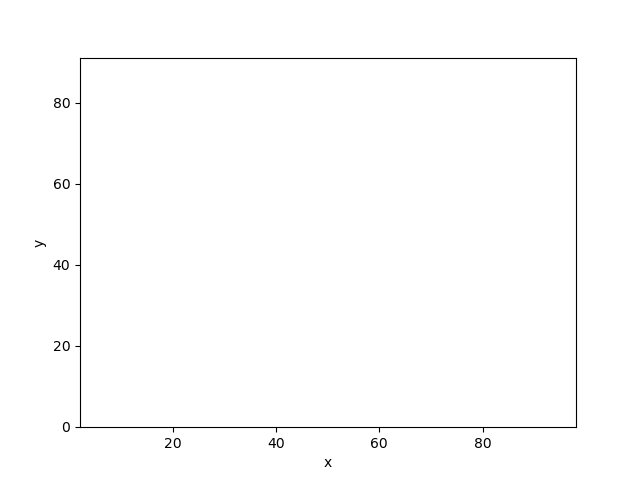

In [110]:
Pol =  [[(np.float64(40.483870967741936), np.float64(75.8116883116883)), (np.float64(19.51612903225806), np.float64(31.16883116883117)), (np.float64(73.38709677419355), np.float64(32.62987012987013))], [(np.float64(40.483870967741936), np.float64(75.8116883116883)), (np.float64(84.19354838709677), np.float64(88.14935064935065)), (np.float64(73.38709677419355), np.float64(32.62987012987013))], [(np.float64(40.483870967741936), np.float64(75.8116883116883)), (np.float64(16.290322580645164), np.float64(87.98701298701297)), (np.float64(19.51612903225806), np.float64(31.16883116883117))], [(np.float64(19.51612903225806), np.float64(31.16883116883117)), (np.float64(23.06451612903226), np.float64(6.1688311688311686)), (np.float64(73.38709677419355), np.float64(32.62987012987013))], [(np.float64(73.38709677419355), np.float64(32.62987012987013)), (np.float64(74.03225806451613), np.float64(11.850649350649352)), (np.float64(93.2258064516129), np.float64(22.88961038961039))]]
Pol =  [[(np.float64(28.548387096774196), np.float64(89.6103896103896)), (np.float64(16.451612903225804), np.float64(34.09090909090909)), (np.float64(55.16129032258064), np.float64(32.30519480519481))], 
[(np.float64(55.16129032258064), np.float64(32.30519480519481)), (np.float64(72.74193548387098), np.float64(90.42207792207793)), (np.float64(82.25806451612904), np.float64(34.253246753246756))], [(np.float64(16.451612903225804), np.float64(34.09090909090909)), (np.float64(19.35483870967742), np.float64(6.493506493506494)), (np.float64(55.16129032258064), np.float64(32.30519480519481))], [(np.float64(55.16129032258064), np.float64(32.30519480519481)), (np.float64(68.87096774193549), np.float64(5.032467532467532)), (np.float64(82.25806451612904), np.float64(34.253246753246756))]]
Pol = Pol =  [[(np.float64(20.96774193548387), np.float64(40.25974025974026)), (np.float64(84.19354838709677), np.float64(39.61038961038961)), (np.float64(90.3225806451613), np.float64(81.98051948051949)), (np.float64(75.64516129032258), np.float64(65.0974025974026)), (np.float64(66.29032258064517), np.float64(83.92857142857142)), (np.float64(55.80645161290323), np.float64(66.88311688311688)), (np.float64(42.903225806451616), np.float64(87.01298701298703)), (np.float64(31.612903225806452), np.float64(60.55194805194805)), (np.float64(17.903225806451612), np.float64(82.95454545454547)), (np.float64(6.451612903225804), np.float64(55.68181818181818))], [(np.float64(20.96774193548387), np.float64(40.25974025974026)), (np.float64(14.032258064516128), np.float64(13.961038961038962)), (np.float64(6.451612903225804), np.float64(55.68181818181818))], [(np.float64(14.032258064516128), np.float64(13.961038961038962)), (np.float64(93.70967741935483), np.float64(4.058441558441558)), (np.float64(84.19354838709677), np.float64(39.61038961038961)), (np.float64(20.96774193548387), np.float64(40.25974025974026))]]

P, E = process_polygons_to_mesh(Pol)
point = (70,60)
vis = animate_point_location(P, E, point)
vis.show_gif()

In [111]:
def generate_tri_grid( width , height ) :
    vertices = []
    edges = []
    for y in range( height + 1 ) :
        for x in range( width + 1 ) :
            vertices.append( (float( x ) , float( y )) )

    def get_idx( x , y ) :
        return y * (width + 1) + x

    for y in range( height ) :
        for x in range( width ) :
            u = get_idx( x , y )
            right = get_idx( x + 1 , y )
            top = get_idx( x , y + 1 )
            top_right = get_idx( x + 1 , y + 1 )
            edges.append( (u , right) )
            edges.append( (u , top) )
            edges.append( (right , top_right) )
            edges.append( (top , top_right) )
            edges.append( (u , top_right) )
    unique_edges = set( )
    for u , v in edges :
        if u < v :
            unique_edges.add( (u , v) )
        else :
            unique_edges.add( (v , u) )
    return vertices , list( unique_edges ) , 0


def generate_quad_grid( width , height , skew = 0.0 ) :
    vertices = []
    edges = []
    for y in range( height + 1 ) :
        shift = y * skew
        for x in range( width + 1 ) :
            vertices.append( (float( x + shift ) , float( y )) )

    def get_idx( x , y ) :
        return y * (width + 1) + x

    for y in range( height + 1 ) :
        for x in range( width ) :
            u = get_idx( x , y )
            v = get_idx( x + 1 , y )
            edges.append( (u , v) )
    for x in range( width + 1 ) :
        for y in range( height ) :
            u = get_idx( x , y )
            v = get_idx( x , y + 1 )
            edges.append( (u , v) )
    unique_edges = set( )
    for u , v in edges :
        if u < v :
            unique_edges.add( (u , v) )
        else :
            unique_edges.add( (v , u) )
    return vertices , list( unique_edges ) , skew


def manual_delaunay_generator( width = 10 , height = 10 , num_points = 15 ) :
    vertices = []
    vertices.extend(
        [(0.0 , 0.0) , (float( width ) , 0.0) , (0.0 , float( height )) , (float( width ) , float( height ))] )

    for _ in range( num_points ) :
        x = random.uniform( 0.1 , width - 0.1 )
        y = random.uniform( 0.1 , height - 0.1 )
        vertices.append( (x , y) )

    n = len( vertices )
    edges = set( )

    # checking every tree point
    for i in range( n ) :
        for j in range( i + 1 , n ) :
            for k in range( j + 1 , n ) :
                x1 , y1 = vertices[i]
                x2 , y2 = vertices[j]
                x3 , y3 = vertices[k]

                # det
                D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))

                # if points are collinear
                if abs( D ) < 1e-5 : continue

                # middle of the circle
                Ux = ((x1 ** 2 + y1 ** 2) * (y2 - y3) + (x2 ** 2 + y2 ** 2) * (y3 - y1) + (x3 ** 2 + y3 ** 2) * (
                        y1 - y2)) / D
                Uy = ((x1 ** 2 + y1 ** 2) * (x3 - x2) + (x2 ** 2 + y2 ** 2) * (x1 - x3) + (x3 ** 2 + y3 ** 2) * (
                        x2 - x1)) / D

                r_sq = (Ux - x1) ** 2 + (Uy - y1) ** 2
                center = (Ux , Uy)

                # Delaunay condition
                is_valid = True
                for m in range( n ) :
                    if m == i or m == j or m == k : continue
                    dist_sq = (vertices[m][0] - center[0]) ** 2 + (vertices[m][1] - center[1]) ** 2

                    if dist_sq < r_sq - 1e-5 :
                        is_valid = False
                        break

                if is_valid :
                    edges.add( tuple( sorted( (i , j) ) ) )
                    edges.add( tuple( sorted( (j , k) ) ) )
                    edges.add( tuple( sorted( (k , i) ) ) )

    edge_list = list( edges )

    # fallback
    if len( edge_list ) == 0 :
        for i in range( len( vertices ) - 1 ) :
            edge_list.append( (i , i + 1) )
        edge_list.append( (len( vertices ) - 1 , 0) )

    return vertices , edge_list , 0

In [112]:
test_graphs = {
    "Prosty_Trojkat" : {
        "V" : [(1 , 1) , (5 , 1) , (3 , 5)] ,
        "E" : [(0 , 1) , (1 , 2) , (0 , 2)] ,
        "points" : [(3 , 2) , (0 , 0) , (3 , 1) , (0 , 3)]
    } ,
    "Kwadrat_z_Przekatna" : {
        "V" : [(0 , 0) , (4 , 0) , (0 , 4) , (4 , 4)] ,
        "E" : [(0 , 1) , (0 , 2) , (1 , 3) , (2 , 3) , (0 , 3)] ,
        "points" : [(1 , 3) , (3 , 1) , (5 , 5)]
    } ,
    "Dwa_Diamenty" : {
        "V" : [(2 , 0) , (0 , 2) , (4 , 2) , (2 , 4) , (2 , 8)] ,
        "E" : [(0 , 1) , (0 , 2) , (1 , 3) , (2 , 3) , (3 , 4)] ,
        "points" : [(2 , 2) , (2 , 6) , (10 , 10)]
    } ,
    "A" : {
        "V" : [(np.float64( 15.483870967741936 ) , np.float64( 9.415584415584416 )) ,
               (np.float64( 80.3225806451613 ) , np.float64( 9.577922077922079 )) ,
               (np.float64( 79.83870967741936 ) , np.float64( 47.72727272727273 )) ,
               (np.float64( 22.903225806451612 ) , np.float64( 63.63636363636363 )) ,
               (np.float64( 72.74193548387098 ) , np.float64( 84.74025974025975 )) ,
               (np.float64( 6.129032258064516 ) , np.float64( 90.9090909090909 ))] ,

        "E" : [(3 , 4) , (2 , 3) , (2 , 4) , (1 , 2) , (0 , 1) , (0 , 2) , (0 , 5) , (3 , 5) , (0 , 3) , (4 , 5)] ,
        "points" : [(20 , 20)]
    } ,
    "B" : {
        "V" : [(np.float64( 96.29032258064517 ) , np.float64( 16.233766233766236 )) ,
               (np.float64( 3.548387096774192 ) , np.float64( 21.753246753246756 )) ,
               (np.float64( 17.419354838709676 ) , np.float64( 36.201298701298704 )) ,
               (np.float64( 91.45161290322581 ) , np.float64( 37.66233766233766 )) ,
               (np.float64( 61.61290322580645 ) , np.float64( 41.55844155844156 )) ,
               (np.float64( 93.70967741935483 ) , np.float64( 66.88311688311688 )) ,
               (np.float64( 16.451612903225804 ) , np.float64( 70.61688311688312 )) ,
               (np.float64( 5.0 ) , np.float64( 78.4090909090909 )) ,
               (np.float64( 43.064516129032256 ) , np.float64( 78.57142857142858 )) ,
               (np.float64( 15.161290322580644 ) , np.float64( 88.3116883116883 )) ,
               (np.float64( 89.6774193548387 ) , np.float64( 90.25974025974025 ))] ,
        "E" : [(9 , 10) , (8 , 10) , (8 , 9) , (5 , 8) , (5 , 10) , (3 , 8) , (3 , 5) , (4 , 8) , (2 , 4) , (2 , 6) ,
               (6 , 8) , (7 , 9) , (6 , 7) , (3 , 4) , (1 , 2) , (0 , 1) , (0 , 4) , (0 , 3) , (1 , 7)] ,
        "points" : [(20 , 0) , (60 , 30) , (80 , 60) , (100 , 80)]
    } ,
    "C" : {
        "V" : [(np.float64( 91.7741935483871 ) , np.float64( 7.305194805194805 )) ,
               (np.float64( 7.096774193548388 ) , np.float64( 9.253246753246753 )) ,
               (np.float64( 22.903225806451612 ) , np.float64( 24.51298701298701 )) ,
               (np.float64( 71.7741935483871 ) , np.float64( 27.272727272727273 )) ,
               (np.float64( 65.48387096774194 ) , np.float64( 60.714285714285715 )) ,
               (np.float64( 22.903225806451612 ) , np.float64( 62.17532467532468 )) ,
               (np.float64( 81.93548387096774 ) , np.float64( 92.53246753246754 )) ,
               (np.float64( 8.225806451612904 ) , np.float64( 94.48051948051949 ))] ,
        "E" : [(6 , 7) , (1 , 7) , (0 , 1) , (0 , 6) , (5 , 7) , (4 , 5) , (4 , 6) , (1 , 2) , (2 , 5) , (2 , 3) ,
               (0 , 3) ,
               (3 , 4)] ,
        "points" : [(10 , 60) , (60 , 80)]
    } ,
    "D" : {
        "V" : [
            (19 , 6) , (85 , 15) , (69 , 31) , (42 , 48) , (54 , 77) ,
            (19 , 83) , (84 , 90)
        ] ,
        "E" : [
            (5 , 6) , (1 , 6) , (0 , 1) , (0 , 5) , (0 , 3) , (3 , 5) , (3 , 4) , (4 , 5) , (4 , 6) , (2 , 4) ,
            (2 , 6) , (1 , 2) , (2 , 3) , (0 , 2)
        ] ,
        "points" : [(25 , 50) , (55 , 60)]
    } ,
    "Zlozony_Wielokat" : {
        "V" : [
            (95 , 6) , (11 , 9) , (33 , 22) , (64 , 36) , (38 , 65) , (72 , 76) ,
            (16 , 86) , (91 , 87)
        ] ,
        "E" : [
            (6 , 7) , (0 , 7) , (0 , 1) , (1 , 6) , (4 , 6) , (2 , 4) , (1 , 2) , (2 , 5) , (4 , 5) , (5 , 7) ,
            (0 , 5) , (0 , 2) , (0 , 3) , (2 , 3) , (3 , 5)
        ] ,
        "points" : [(45 , 70) , (50 , 35) , (20 , 50) , (70 , 50) , (50 , 10)]
    } ,
}

# tri grid
v_tri , e_tri , _ = generate_tri_grid( 3 , 3 )
test_graphs["tri_grid_3x3"] = {
    "V" : v_tri ,
    "E" : e_tri ,
    "points" : [(0.75 , 0.5) , (1.5 , 1.25) , (1.5 , 1.75) , (3 , 3.5) , (3.5 , 3.5)]
}

v_tri , e_tri , _ = generate_tri_grid( 5 , 5 )
test_graphs["tri_grid_5x5"] = {
    "V" : v_tri ,
    "E" : e_tri ,
    "points" : [(0.75 , 0.5) , (1.5 , 1.2) , (1.5 , 1.5) , (5 , 5) , (3 , 0) , ( 3.75,1.5) , (3.75 , 3.5) ]
}

# quad grid
v_quad , e_quad , _ = generate_quad_grid( 4 , 2 , 1 )
test_graphs["quad_grid_4x2_Skew_1"] = {
    "V" : v_quad ,
    "E" : e_quad ,
    "points" : [(0.75 , 0.5) , (1.5 , 1.2) , (1.5 , 1.5) , (3 , 0)]
}
v_quad , e_quad , _ = generate_quad_grid( 5 , 5 , 0 )
test_graphs["quad_grid_5x5_Skew_0"] = {
    "V" : v_quad ,
    "E" : e_quad ,
    "points" : [(0.75 , 0.5) , (1.5 , 1.2) , (1.5 , 1.5) , (5 , 5) , (3 , 0) , (5.5 , 5.5) ]
}
v_quad , e_quad , _ = generate_quad_grid( 2 , 2 , 0 )
test_graphs["quad_grid_2x2_Skew_0"] = {
    "V" : v_quad ,
    "E" : e_quad ,
    "points" : [ (0.5,0.5) , (3,1.5) ,(3 , 3 ) , (1.5,0.5)]
}

#delunay
v_quad , e_quad , _ = manual_delaunay_generator( 20 , 20 , 30 )
test_graphs["deluanay_20_20_30"] = {
    "V" : v_quad ,
    "E" : e_quad ,
    "points" : [(0.75 , 0.5) , (1.5 , 1.2) , (1.5 , 1.5) , (5 , 5) , (3 , 0) , (5.5 , 5.5) , (6.5 , 7.5)]
}
v_quad , e_quad , _ = manual_delaunay_generator( 10 , 10 , 30 )
test_graphs["deluanay_10_10_30"] = {
    "V" : v_quad ,
    "E" : e_quad ,
    "points" : [(0.75 , 0.5) , (1.5 , 1.2) , (1.5 , 1.5) , (5 , 5) , (3 , 0) , (5.5 , 5.5) , (6.5 , 7.5)]
}

In [113]:
# Uruchomienie testów
for graph_name , data in test_graphs.items( ) :
    V = data["V"]
    E = data["E"]
    points = data["points"]

    print( f"   Testowany: {graph_name}" )

    for point in points :
        try :
            vis , found_edges = separators_method_point_location_algorithm_visualiser( V , E , point )
            #vis.show( )
            dir = "Imgs"
            ensure_image_directory( dir )
            filePath = os.path.join( dir , f"{graph_name}_pkt_{int( point[0] )}_{int( point[1] )}" )
            vis.save( filePath )

            vis = animate_point_location( V , E , point )
            dir = "Gifs"
            ensure_image_directory( dir )
            filePath = os.path.join( dir , f"{graph_name}_pkt_{int( point[0] )}_{int( point[1] )}" )
            vis.save_gif( filePath )
            print( f"Punkt {point}: znaleziono {len( found_edges )} krawędzi: {found_edges}" )
        except Exception as e :
            print( f"Błąd {graph_name} przy punkcie {point}: {e}" )

   Testowany: Prosty_Trojkat
Punkt (3, 2): znaleziono 3 krawędzi: [((1, 1), (3, 5)), ((1, 1), (5, 1)), ((5, 1), (3, 5))]
Punkt (0, 0): znaleziono 0 krawędzi: []
Punkt (3, 1): znaleziono 1 krawędzi: [((1, 1), (5, 1))]
Punkt (0, 3): znaleziono 0 krawędzi: []
   Testowany: Kwadrat_z_Przekatna
Punkt (1, 3): znaleziono 3 krawędzi: [((0, 0), (0, 4)), ((0, 4), (4, 4)), ((0, 0), (4, 4))]
Punkt (3, 1): znaleziono 3 krawędzi: [((0, 0), (4, 4)), ((0, 0), (4, 0)), ((4, 0), (4, 4))]
Punkt (5, 5): znaleziono 0 krawędzi: []
   Testowany: Dwa_Diamenty
Punkt (2, 2): znaleziono 4 krawędzi: [((2, 0), (0, 2)), ((0, 2), (2, 4)), ((2, 0), (4, 2)), ((4, 2), (2, 4))]
Punkt (2, 6): znaleziono 1 krawędzi: [((2, 4), (2, 8))]
Punkt (10, 10): znaleziono 0 krawędzi: []
   Testowany: A
Punkt (20, 20): znaleziono 3 krawędzi: [((np.float64(15.483870967741936), np.float64(9.415584415584416)), (np.float64(22.903225806451612), np.float64(63.63636363636363))), ((np.float64(15.483870967741936), np.float64(9.415584415584416

In [119]:
grid_sizes = [10 , 50 , 100 , 150 , 200 , 400]  #, 600]
result_list = []
ReportsDir = "Reports/"

test_configs = [
    ('TriGrid' , generate_tri_grid) ,
    ('QuadGrid' , generate_quad_grid)
]

for type_name , generator_func in test_configs :
    print( f"Rozpoczynam benchmark dla: {type_name}" )

    for N in grid_sizes :
        vertices , edges , _ = generator_func( N , N )
        setNum = len( vertices )

        t0 = time( )
        try :
            graph = build_graph( vertices , edges )
            compute_planar_weights( graph )
            separators = generate_monotone_chains( graph )
            bst_root = create_search_structure( separators )
            build_time = time( ) - t0

            query_count = 100
            test_points = [(random.uniform( 0 , N ) , random.uniform( 0 , N )) for _ in range( query_count )]

            t1 = time( )
            for p in test_points :
                query_search_tree( p , bst_root , closest_left = separators[0] , closest_right = separators[-1] )
            query_time_total = time( ) - t1
            avg_query_time = query_time_total / query_count

            result_list.append( {
                'Typ Grafu' : type_name ,
                'Liczba V' : setNum ,
                'Liczba E' : len( edges ) ,
                'Czas Budowy [s]' : build_time ,
                'Czas Zapytania [s]' : avg_query_time
            } )
            print( f"  Zakończono dla V={setNum}" )

        except Exception as e :
            print( f"  Błąd podczas przetwarzania {type_name} dla V={setNum}: {e}" )

print( f"Rozpoczynam benchmark dla: delunay" )

for N in grid_sizes :

    vertices , edges , _ = manual_delaunay_generator( N , N , N*N )
    setNum = len( vertices )
    type_name = "delanuay"
    t0 = time( )
    try :
        graph = build_graph( vertices , edges )
        compute_planar_weights( graph )
        separators = generate_monotone_chains( graph )
        bst_root = create_search_structure( separators )
        build_time = time( ) - t0

        query_count = 100
        test_points = [(random.uniform( 0 , N ) , random.uniform( 0 , N )) for _ in range( query_count )]

        t1 = time( )
        for p in test_points :
            query_search_tree( p , bst_root , closest_left = separators[0] , closest_right = separators[-1] )
        query_time_total = time( ) - t1
        avg_query_time = query_time_total / query_count

        result_list.append( {
            'Typ Grafu' : type_name ,
            'Liczba V' : setNum ,
            'Liczba E' : len( edges ) ,
            'Czas Budowy [s]' : build_time ,
            'Czas Zapytania [s]' : avg_query_time
        } )
        print( f"  Zakończono dla V={setNum}" )

    except Exception as e :
        print( f"  Błąd podczas przetwarzania {type_name} dla V={setNum}: {e}" )

final_dataframe = pd.DataFrame( result_list )
print( "\nWyniki końcowe:" )
print( final_dataframe )

dir = "Reports"
file = 'Benchmark_Separatory_Full.csv'

ensure_image_directory( dir )
filePath = os.path.join( dir , file )
final_dataframe.to_csv( filePath , index = False )

Rozpoczynam benchmark dla: TriGrid
  Zakończono dla V=121
  Zakończono dla V=2601
  Zakończono dla V=10201
  Zakończono dla V=22801
  Zakończono dla V=40401
  Zakończono dla V=160801
Rozpoczynam benchmark dla: QuadGrid
  Zakończono dla V=121
  Zakończono dla V=2601
  Zakończono dla V=10201
  Zakończono dla V=22801
  Zakończono dla V=40401
  Zakończono dla V=160801
Rozpoczynam benchmark dla: delunay
  Zakończono dla V=104


KeyboardInterrupt: 

In [118]:
import matplotlib.pyplot as plt

def plot_benchmark_results(dataframe, output_dir="Reports"):
    """
    Tworzy dwa wykresy: czas budowy i czas zapytania vs liczba wierzchołków
    """
    ensure_image_directory(output_dir)

    types = dataframe['Typ Grafu'].unique()
    colors = {'TriGrid': 'blue', 'QuadGrid': 'green', 'delanuay': 'red'}
    markers = {'TriGrid': 'o', 'QuadGrid': 's', 'delanuay': '^'}

    plt.figure(figsize=(12, 6))

    for graph_type in types:
        data = dataframe[dataframe['Typ Grafu'] == graph_type]
        plt.plot(data['Liczba V'], data['Czas Budowy [s]'],
                marker=markers.get(graph_type, 'o'),
                color=colors.get(graph_type, 'black'),
                label=graph_type, linewidth=2, markersize=8)

    plt.xlabel('Liczba Wierzchołków', fontsize=12)
    plt.ylabel('Czas Budowy [s]', fontsize=12)
    plt.title('Czas Budowy Struktury vs Liczba Wierzchołków', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'build_time_vs_vertices.png'), dpi=300)
    plt.close()

    plt.figure(figsize=(12, 6))

    for graph_type in types:
        data = dataframe[dataframe['Typ Grafu'] == graph_type]
        plt.plot(data['Liczba V'], data['Czas Zapytania [s]'] * 1000,
                marker=markers.get(graph_type, 'o'),
                color=colors.get(graph_type, 'black'),
                label=graph_type, linewidth=2, markersize=8)

    plt.xlabel('Liczba Wierzchołków', fontsize=12)
    plt.ylabel('Czas Zapytania [ms]', fontsize=12)
    plt.title('Czas Zapytania vs Liczba Wierzchołków', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'query_time_vs_vertices.png'), dpi=300)
    plt.close()

plot_benchmark_results(final_dataframe )